### Import

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import metrics
import os

### Definisi Class

In [8]:
class ImageEnhancer:
    def __init__(self):
        self.results = {}
    
    def load_image(self, image_path):
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Tidak dapat membaca gambar {image_path}")
            return None
        if len(img.shape) == 3:
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            img_gray = img
        return img_gray
    
    def histogram_equalization(self, image):
        hist, bins = np.histogram(image.flatten(), 256, [0, 256])
        cdf = hist.cumsum()
        cdf_normalized = cdf * 255 / cdf[-1]
        equalized = np.interp(image.flatten(), bins[:-1], cdf_normalized)
        return equalized.reshape(image.shape).astype(np.uint8)
    
    def clahe_enhancement(self, image, clip_limit=2.0, tile_grid_size=(8, 8)):
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        return clahe.apply(image)
    
    def calculate_metrics(self, original, enhanced, method_name):
        mean_orig = np.mean(original)
        std_orig = np.std(original)
        mean_enh = np.mean(enhanced)
        std_enh = np.std(enhanced)
        
        contrast_orig = std_orig / mean_orig if mean_orig != 0 else 0
        contrast_enh = std_enh / mean_enh if mean_enh != 0 else 0
        enhancement_factor = contrast_enh / contrast_orig if contrast_orig != 0 else 0
        
        mse = np.mean((original.astype(float) - enhanced.astype(float)) ** 2)
        psnr = 20 * np.log10(255.0 / np.sqrt(mse)) if mse != 0 else float('inf')
        ssim = metrics.structural_similarity(original, enhanced, data_range=255)
        
        return {
            'method': method_name,
            'mean_original': mean_orig,
            'std_original': std_orig,
            'mean_enhanced': mean_enh,
            'std_enhanced': std_enh,
            'contrast_original': contrast_orig,
            'contrast_enhanced': contrast_enh,
            'enhancement_factor': enhancement_factor,
            'psnr': psnr,
            'ssim': ssim
        }
    
    def plot_histogram(self, images, titles, filename=None):
        plt.figure(figsize=(15, 5))
        for i, (img, title) in enumerate(zip(images, titles)):
            plt.subplot(1, len(images), i+1)
            plt.hist(img.flatten(), bins=256, range=[0, 256], alpha=0.7)
            plt.title(f'Histogram - {title}')
            plt.xlabel('Intensity')
            plt.ylabel('Frequency')
            plt.grid(True, alpha=0.3)
        plt.tight_layout()
        if filename:
            plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_comparison(self, images, titles, filename=None):
        plt.figure(figsize=(15, 5))
        for i, (img, title) in enumerate(zip(images, titles)):
            plt.subplot(1, len(images), i+1)
            plt.imshow(img, cmap='gray')
            plt.title(title)
            plt.axis('off')
        plt.tight_layout()
        if filename:
            plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()


### Proses Citra

In [9]:
def process_image(enhancer, image_path, image_name):
    print(f"\n=== Memproses {image_name} ===")
    original = enhancer.load_image(image_path)
    if original is None:
        return None

    he_result = enhancer.histogram_equalization(original)
    clahe_result = enhancer.clahe_enhancement(original)

    he_metrics = enhancer.calculate_metrics(original, he_result, "Histogram Equalization")
    clahe_metrics = enhancer.calculate_metrics(original, clahe_result, "CLAHE")

    enhancer.results[image_name] = {
        'original': original,
        'he': he_result,
        'clahe': clahe_result,
        'he_metrics': he_metrics,
        'clahe_metrics': clahe_metrics
    }

    enhancer.plot_comparison([original, he_result, clahe_result], ['Original', 'HE', 'CLAHE'])
    enhancer.plot_histogram([original, he_result, clahe_result], ['Original', 'HE', 'CLAHE'])

    return he_metrics, clahe_metrics


### Cetak Metrik

In [10]:
def print_metrics(he_metrics, clahe_metrics, image_name):
    print(f"\nMetrik untuk {image_name}:")
    print("="*60)
    print(f"{'Metrik':<25} {'Original':<15} {'HE':<15} {'CLAHE':<15}")
    print("-"*60)
    print(f"{'Mean Intensity':<25} {he_metrics['mean_original']:<15.2f} {he_metrics['mean_enhanced']:<15.2f} {clahe_metrics['mean_enhanced']:<15.2f}")
    print(f"{'Std Deviation':<25} {he_metrics['std_original']:<15.2f} {he_metrics['std_enhanced']:<15.2f} {clahe_metrics['std_enhanced']:<15.2f}")
    print(f"{'Contrast Ratio':<25} {he_metrics['contrast_original']:<15.3f} {he_metrics['contrast_enhanced']:<15.3f} {clahe_metrics['contrast_enhanced']:<15.3f}")
    print(f"{'Enhancement Factor':<25} {'-':<15} {he_metrics['enhancement_factor']:<15.2f} {clahe_metrics['enhancement_factor']:<15.2f}")
    print(f"{'PSNR (dB)':<25} {'-':<15} {he_metrics['psnr']:<15.2f} {clahe_metrics['psnr']:<15.2f}")
    print(f"{'SSIM':<25} {'-':<15} {he_metrics['ssim']:<15.3f} {clahe_metrics['ssim']:<15.3f}")


### Jalankan Semua (Testing)


=== Memproses Citra 1 ===


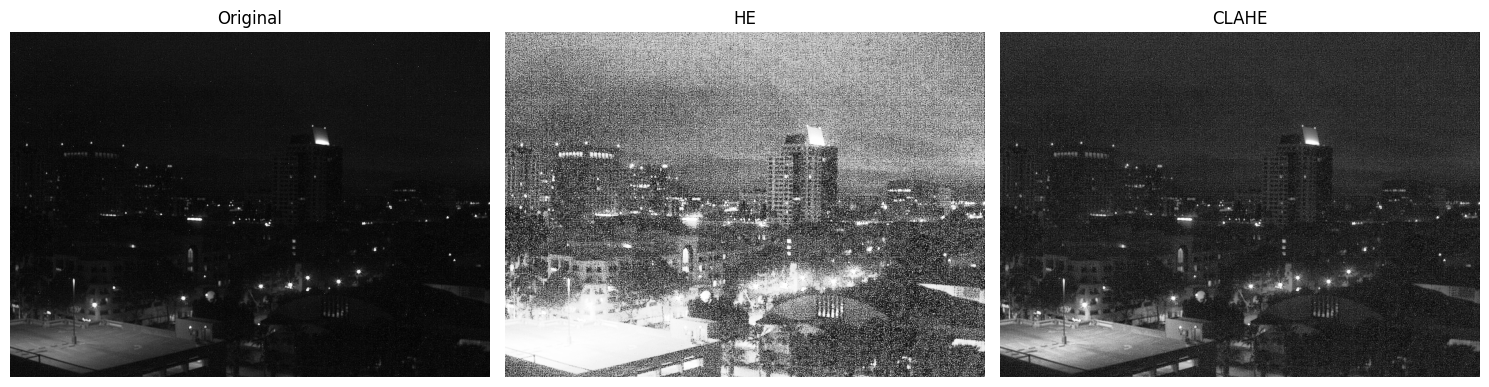

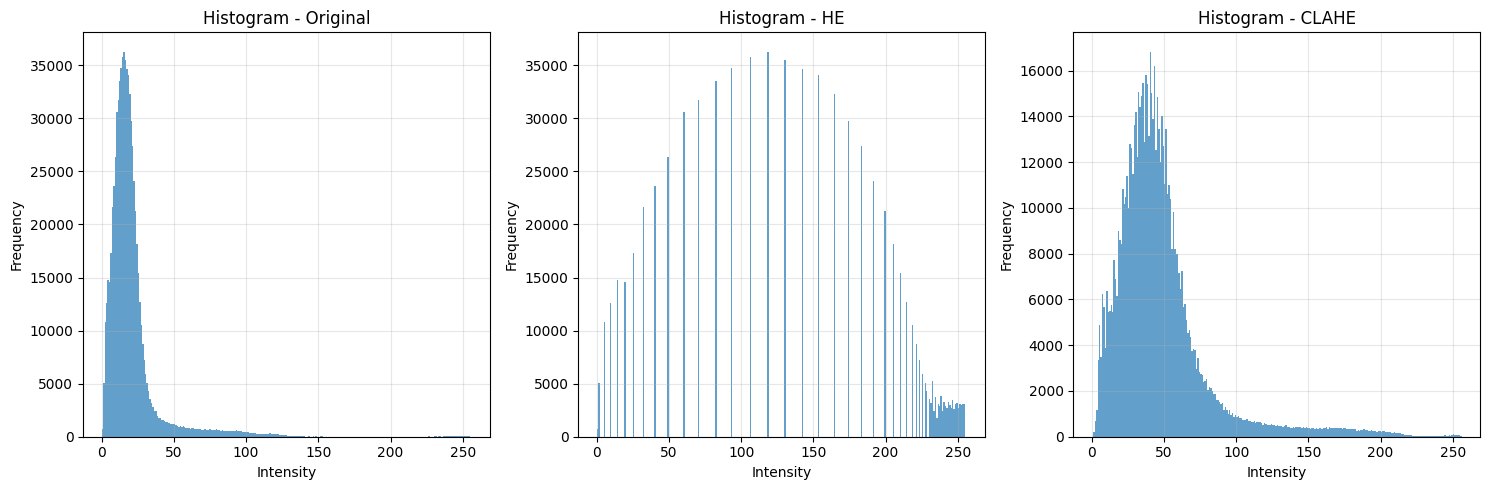


Metrik untuk Citra 1:
Metrik                    Original        HE              CLAHE          
------------------------------------------------------------
Mean Intensity            20.52           131.02          47.75          
Std Deviation             20.25           72.90           33.68          
Contrast Ratio            0.987           0.556           0.705          
Enhancement Factor        -               0.56            0.71           
PSNR (dB)                 -               6.11            18.17          
SSIM                      -               0.088           0.515          

=== Memproses Citra 2 ===


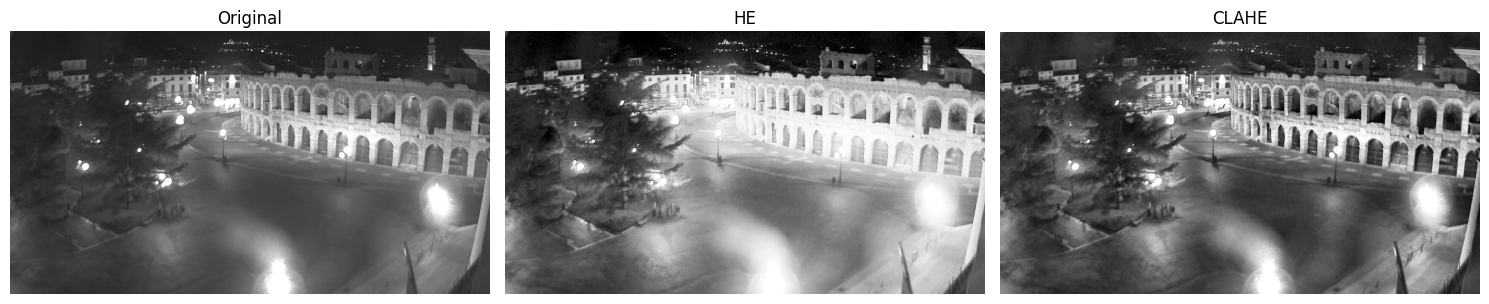

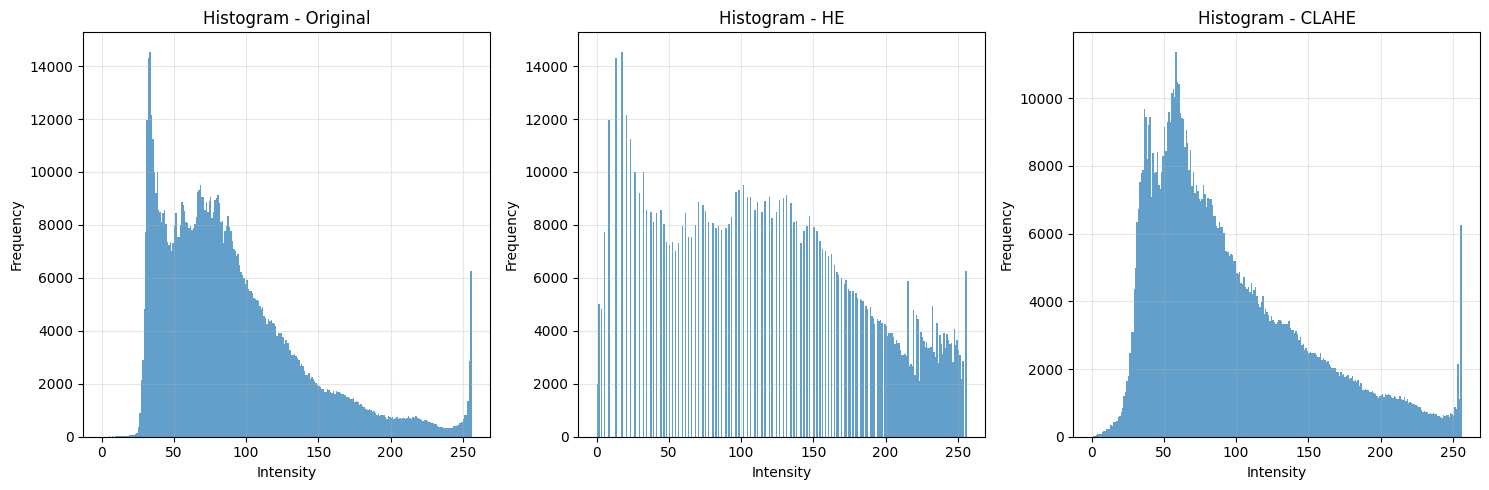


Metrik untuk Citra 2:
Metrik                    Original        HE              CLAHE          
------------------------------------------------------------
Mean Intensity            89.73           127.98          95.20          
Std Deviation             49.72           73.23           54.42          
Contrast Ratio            0.554           0.572           0.572          
Enhancement Factor        -               1.03            1.03           
PSNR (dB)                 -               14.07           21.64          
SSIM                      -               0.815           0.891          

=== Memproses Citra 3 ===


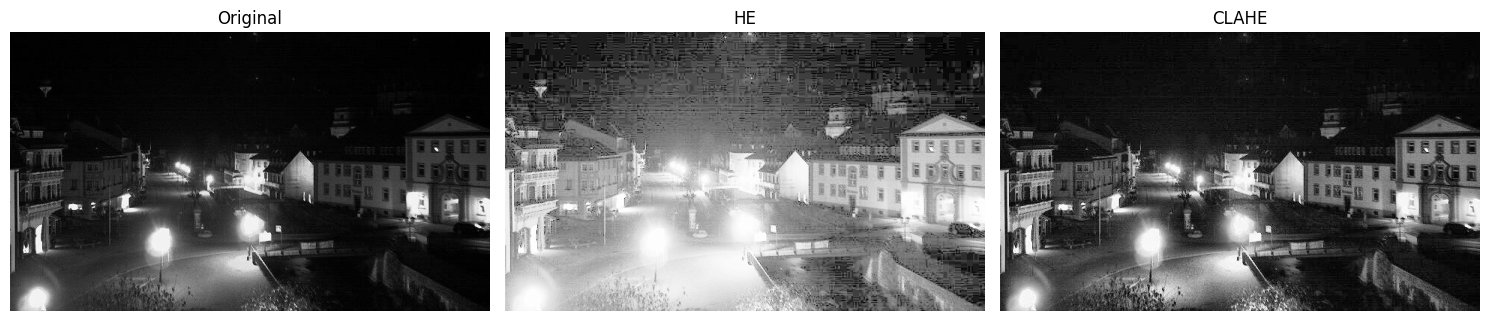

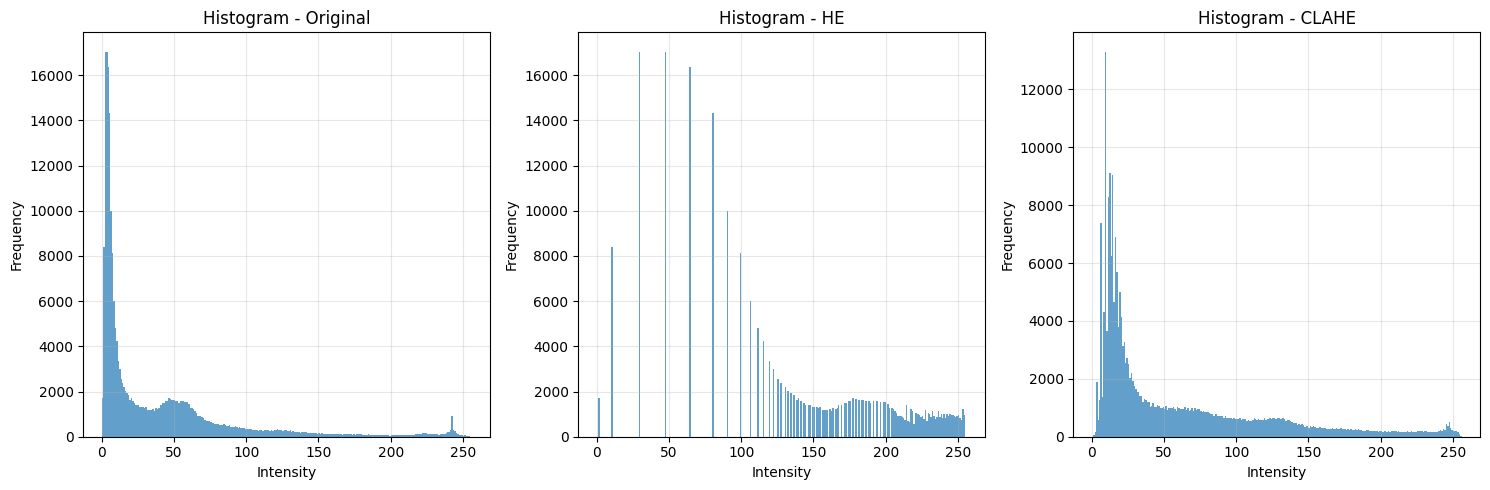


Metrik untuk Citra 3:
Metrik                    Original        HE              CLAHE          
------------------------------------------------------------
Mean Intensity            38.24           130.47          58.72          
Std Deviation             51.08           70.54           60.63          
Contrast Ratio            1.336           0.541           1.033          
Enhancement Factor        -               0.40            0.77           
PSNR (dB)                 -               8.04            19.16          
SSIM                      -               0.263           0.650          


In [5]:
# Inisialisasi
enhancer = ImageEnhancer()

files = ['citra1.jpg', 'citra2.jpg', 'citra3.jpg']

# Proses semua citra
for i, file in enumerate(files, 1):
    image_name = f"Citra {i}"
    he_metrics, clahe_metrics = process_image(enhancer, file, image_name)
    print_metrics(he_metrics, clahe_metrics, image_name)